# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [ ]:
!pip install datasets

Download the dataset

In [2]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

2024-06-11 09:52:33.364091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 09:52:33.364215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 09:52:33.489217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter row with length greater than 8.


In [4]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)

Filter:   0%|          | 0/462393 [00:00<?, ? examples/s]

Create a tokenizer and Detokenizer

In [5]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [6]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [7]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [8]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [9]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [10]:
train_generator = DataGenerator(shuffled_data[:220000])
test_generator = DataGenerator(shuffled_data[220000:])

In [11]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")

original:  <start> ranchers clear large areas of rainforest to become pastures for their cattle <end>
shuffled:  <start> large their areas for cattle ranchers rainforest clear pastures become to of <end>


original:  <start> some earwigs have stripes on the thorax and abdomen <end>
shuffled:  <start> stripes thorax some and the earwigs on abdomen have <end>


original:  <start> magnetic manipulation can turn molecules in a liquid into computing such devices <end>
shuffled:  <start> into in magnetic such a liquid molecules can manipulation computing turn devices <end>


original:  <start> healthy wetlands means cleaner water <comma> reduced flooding and more places for recreation <end>
shuffled:  <start> reduced wetlands and recreation for water places healthy cleaner flooding <comma> means more <end>


original:  <start> market share is the percent share in sales one company controls in a particular market <end>
shuffled:  <start> company percent share one controls a sales in market is

In [12]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  return (match.size/max(len(p),len(s)))

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.

The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

Let's do an example.

In [13]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

## Methodology
1. **Data Preparation:**
   - Currently, we have pairs of a shuffled sentence and an ordered one.
   - I am going to split the data into triplets:
       - the first element of the triplet is the context - the shuffled sentence
       - the second element is the decoder input - beginning of the ordered sentence with start token at the beginning
       - the third one is the label - the ordered sentence

2. **Model Architecture:**
    - I am going to implement a transformer which is going to predict the probabilities for each sentence element for each token.
    - The idea is that when we pass the shuffled sentence and a part of the original sentence, the model is going to be able to predict the most probable value for the next element in the sentence.

3. **Prediction Procedure:**
    - Initial Step: Start with the shuffled sentence and a start token as the decoder input.
    - Prediction Loop:
        - The model predicts the most probable token on the position of the last non-empty element in the decoder input. In the first iteration, this will be the first element of the sentence.
        - This predicted token will be selected only from the tokens present in the shuffled sentence.
        - Concatenate this token to the decoder input, forming a new decoder input.
        - Repeat this process until all tokens of the ordered sentence are predicted.
    - Token Selection: Each predicted token will be chosen only from the remaining unused tokens in the shuffled sentence.

In [14]:
import numpy as np
import tensorflow as tf
import keras.backend as k
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
import keras
from keras.callbacks import Callback

## Dataset

We are going to create a new data generator which will return the batches of context, decoder inputs and labels.

In [15]:
VOCAB_SIZE = len(tokenizer.get_vocabulary())
BATCH_SIZE = 128
SEQ_LEN = shuffled_data.shape[1]

In [16]:
def extract_full_data(generator):
    x_list = []
    y_list = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x_list.append(x_batch)
        y_list.append(y_batch)
    x = np.concatenate(x_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return x, y

We are extracting x_test and y_test only for test purposes. They will not be used in the training.

In [18]:
x_test, y_test = extract_full_data(test_generator)
x_test.shape, y_test.shape

((21216, 28), (21216, 28))

In [17]:
def prepare_dataset(X, Y):
    c_set = pad_sequences(np.array([s[1:] for s in X]), maxlen=28, padding='post')
    x_set = Y
    y_set = pad_sequences(np.array([s[1:] for s in Y]), maxlen=28, padding='post')
    context = []
    labels = []
    inputs= []

    for j, x in enumerate(x_set):
        non_null_count = sum(x > 0) - 2
        for i in range(non_null_count):
            context.append(c_set[j])
            inputs.append(pad_sequences([x[:i+1]], maxlen=28, padding='post')[0])
            labels.append(y_set[j])

    return np.array(context), np.array(inputs), np.array(labels)


class TrasnformerDataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data_generator = DataGenerator(data, batch_size=batch_size)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        x, y = extract_full_data(self.data_generator)
        self.dataset = prepare_dataset(x, y)
        self.indexes = np.arange(len(self.dataset[0]))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataset[0]) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        context = self.dataset[0][indexes].copy()
        inputs = self.dataset[1][indexes].copy()
        labels = self.dataset[2][indexes].copy()
        return (context, inputs), labels

    def on_epoch_end(self):
        self.data_generator.on_epoch_end()
        x, y = extract_full_data(self.data_generator)
        self.dataset = prepare_dataset(x, y)
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

We are initializing data generators which will be utilized during training.

In [19]:
transformer_train_generator = TrasnformerDataGenerator(shuffled_data[:200000], batch_size=BATCH_SIZE)
transformer_val_generator = TrasnformerDataGenerator(shuffled_data[200000:220000], batch_size=BATCH_SIZE)

## Model

In [20]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedder, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = embedder
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

In [21]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()
    def call(self, x, context):
        attn_output, att_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True
        )
        self.last_attn_scores = att_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, use_causal_mask=False, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.add = tf.keras.layers.Add()
        self.use_causal_mask = use_causal_mask

    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask=self.use_causal_mask
        )
        x = self.add([x, attn_output])
        return self.layernorm(x)

In [22]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='swish'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = SelfAttention(use_causal_mask=False,
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        return self.ffn(x)


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads,dff,dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = SelfAttention(use_causal_mask=True,
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        return self.ffn(x)

In [24]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, embedder, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embedder

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x



class Decoder(tf.keras.layers.Layer):
    def __init__(self, embedder, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(embedder, vocab_size=vocab_size, d_model=d_model)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

    def call(self, x, context):
        x = self.pos_embedding(x)  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)
        return x

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               vocab_size, dropout_rate=0.1):
        super().__init__()
        self.embedder = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.encoder = Encoder(self.embedder,num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(self.embedder,num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        context, x  = inputs
        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        logits = self.final_layer(x)  # (batch_size, target_len, vocab_size)

        try:
            del logits._keras_mask
        except AttributeError:
            pass
        return logits

## Training

In [26]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_embedding, warmup_steps=5000):
        super().__init__()

        self.d_embedding = d_embedding
        self.d_embedding = tf.cast(self.d_embedding, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_embedding) * tf.math.minimum(arg1, arg2)


In [27]:
K_VALUE = 0.97

def loss(label, pred):
    mask = label != 0
    cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = cross_entropy(label, pred)

    first_part = tf.pow(K_VALUE, tf.cast(tf.range(1, 6 + 1), tf.float32))
    second_part = tf.pow(K_VALUE, tf.cast(tf.range(1, SEQ_LEN - 6 + 1), tf.float32))

    reversed_first_part = tf.reverse(first_part, axis=[0])

    final_array = tf.concat([reversed_first_part, second_part], axis=0)
    mask = tf.cast(mask, dtype=loss.dtype)
    mask*=final_array

    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [30]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [31]:
num_layers = 8
d_embedding = 128
d_feed_forward = 512
num_heads = 8
dropout_rate = 0.2
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_embedding,
    num_heads=num_heads,
    dff=d_feed_forward,
    vocab_size=VOCAB_SIZE,
    dropout_rate=dropout_rate)
learning_rate = LearningRateScheduler(d_embedding, warmup_steps=10000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


transformer.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[accuracy])

transformer.build(input_shape = [(None, SEQ_LEN), (None, SEQ_LEN)])

We are creating a custom callback which is going to track the validation loss and the validation accuracy during the epoch. This is essential because the model can overfit in less than 3 epochs. So we need to be able to track its performance and act accordingly before that.

In [34]:
class SaveBestWeight(Callback):
    def __init__(self, transformer_val_generator, steps=6000, patience=2):
        super(SaveBestWeight, self).__init__()
        self.transformer_val_generator = transformer_val_generator
        self.steps = steps
        self.best_val_loss = float('inf')
        self.best_accuracy = 0
        self.wait = 0  # Counter for how many epochs the accuracy hasn't improved
        self.patience = patience  # Number of epochs to wait before early stopping

    def on_batch_end(self, batch, logs=None):
        if batch > 0 and batch % self.steps == 0:
            val_loss, val_accuracy = self.model.evaluate(self.transformer_val_generator, verbose=0)
            print(f'\nBatch {batch}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            # Check if current accuracy is better than the best so far
            if val_accuracy > self.best_accuracy:
                print(f'\nAccuracy improved from {self.best_accuracy:.4f} to {val_accuracy:.4f}. Saving weights.')
                self.best_accuracy = val_accuracy
                self.model.save_weights('best.weights.h5')  # Save best weights
                self.wait = 0  # Reset wait counter
            else:
                self.wait += 1
                # If accuracy hasn't improved for patience epochs, stop training
                if self.wait >= self.patience:
                    print(f'\nAccuracy did not improve for {self.patience} epochs. Early stopping.')
                    self.model.stop_training = True

In [35]:
print_val_loss_callback = SaveBestWeight(transformer_val_generator=transformer_val_generator, steps=3000, patience=4)


epochs = 3

history = transformer.fit(
    transformer_train_generator,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    callbacks=[print_val_loss_callback],
    validation_data = transformer_val_generator
)

Epoch 1/3


I0000 00:00:1718100126.817323     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718100126.918238     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3000/19266 ━━━━━━━━━━━━━━━━━━━━ 32:38 120ms/step - accuracy: 0.1811 - loss: 7.2057

W0000 00:00:1718100495.677613     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Batch 3000: Validation Loss: 3.4365, Validation Accuracy: 0.4368

Accuracy improved from 0.0000 to 0.4368. Saving weights.
 6000/19266 ━━━━━━━━━━━━━━━━━━━━ 29:45 135ms/step - accuracy: 0.3175 - loss: 5.1873
Batch 6000: Validation Loss: 1.9990, Validation Accuracy: 0.5365

Accuracy improved from 0.4368 to 0.5365. Saving weights.
 9000/19266 ━━━━━━━━━━━━━━━━━━━━ 23:40 138ms/step - accuracy: 0.3940 - loss: 4.0890
Batch 9000: Validation Loss: 1.6771, Validation Accuracy: 0.5772

Accuracy improved from 0.5365 to 0.5772. Saving weights.
12000/19266 ━━━━━━━━━━━━━━━━━━━━ 16:56 140ms/step - accuracy: 0.4424 - loss: 3.4641
Batch 12000: Validation Loss: 1.5050, Validation Accuracy: 0.6122

Accuracy improved from 0.5772 to 0.6122. Saving weights.
15000/19266 ━━━━━━━━━━━━━━━━━━━━ 10:01 141ms/step - accuracy: 0.4800 - loss: 3.0479
Batch 15000: Validation Loss: 1.3857, Validation Accuracy: 0.6385

Accuracy improved from 0.6122 to 0.6385. Saving weights.
18000/19266 ━━━━━━━━━━━━━━━━━━━━ 2:59 142ms/st

In [37]:
transformer.load_weights('best.weights.h5')

In [41]:
val_loss, val_accuracy = transformer.evaluate(transformer_val_generator, verbose=0)

In [42]:
print(f'Validation Accuracy: {val_accuracy}')

Validation Accuracy: 0.695848822593689


In [43]:
transformer.summary()

Model: "transformer_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Encoder)             │ ?                      │     6,557,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │    10,779,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ ?                      │     1,290,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,042,033 (198.52 MB)

 Trainable params: 17,347,344 (66.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,694,689 (132.35 MB)

In [44]:
print(f"Parameters' count: {transformer.count_params()}")

Parameters' count: 17347344


## Prediction

In [45]:
def generate_prediction(shuffled, model):
    max_count = sum(shuffled > 3)
    generated = pad_sequences(np.array([shuffled[:1]]), maxlen=28, padding='post')[0]
    available_tokens = shuffled[1:sum((shuffled>0))-1].tolist()
    context = pad_sequences(np.array([shuffled[1:]]), maxlen=28, padding='post')[0]

    for count in range(max_count):
        prediction = model.predict((np.array([context]), np.array([generated])), verbose=0)
        relevant_logits = prediction[0, count, available_tokens]
        generated_index = np.argmax(relevant_logits, axis=-1)
        generated_token = available_tokens[generated_index]
        available_tokens.remove(generated_token)
        generated[count+1] = generated_token

    return generated[1:sum(generated>0)]

## Testing

In [60]:
def get_average_score(x, y, model, print_allowed=False):
    num_examples = len(x)
    generated_scores = []
    for i in range(num_examples):
        ordered = y[i][1:sum(y[i]>0)-1]
        detokenized_ordered = detokenizer([ordered])[0]
        detokenized_prediction = detokenizer([generate_prediction(x[i],model)])[0]
        generated_scores.append(score(detokenized_ordered, detokenized_prediction))
        if print_allowed and (i+1)%200 == 0:
            print(f'{i+1}.Ordered sentence: {detokenized_ordered}')
            print(f'{i+1}.Generated sentence: {detokenized_prediction}')
            print(f'Average over {i+2-200}-{i+1}: {sum(generated_scores[-200:])/200}')

    return generated_scores, sum(generated_scores)/num_examples

In [55]:
x_test_length = len(x_test)

# Generate 3000 random indices
random_indices = np.random.choice(x_test_length, 3000, replace=False)

In [61]:
generated_scores, average_generated_score = get_average_score(x_test[random_indices], y_test[random_indices], transformer, print_allowed=True)
print(f'Average score on generated data: {average_generated_score}')

200.Ordered sentence: human geography is the part of the field devoted to understanding systems that include people
200.Generated sentence: human geography is devoted to the understanding systems of the field that include people part
Average over 1-200: 0.5569576918245007
400.Ordered sentence: viscosity is a measure of resistance to local change
400.Generated sentence: viscosity is a measure of local resistance to change
Average over 201-400: 0.5363243618353546
600.Ordered sentence: most studies show that single homeless adults are more likely to be male than female
600.Generated sentence: most studies show that female adults are more likely to be homeless than single male
Average over 401-600: 0.5141895636355579
800.Ordered sentence: insomnia is an inability to fall or to stay asleep
800.Generated sentence: insomnia is an inability to stay asleep or to fall
Average over 601-800: 0.5321494141276077
1000.Ordered sentence: microwaves selectively heat with little direct heating of most so

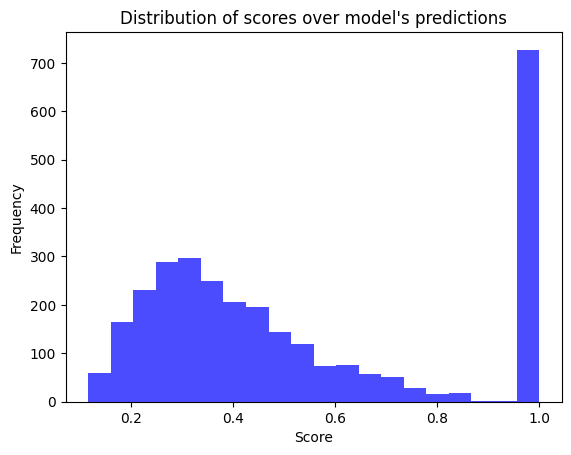

In [62]:
import matplotlib.pyplot as plt
import numpy as np


plt.hist(generated_scores, bins=20, alpha=0.7, color='blue')

plt.title("Distribution of scores over model's predictions")
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.show()

## Previous attempts

I tried implementing a Decoder-only transformer which would be able to receive the shuffled sentence and return the original one. However, the results were not satisfactory.